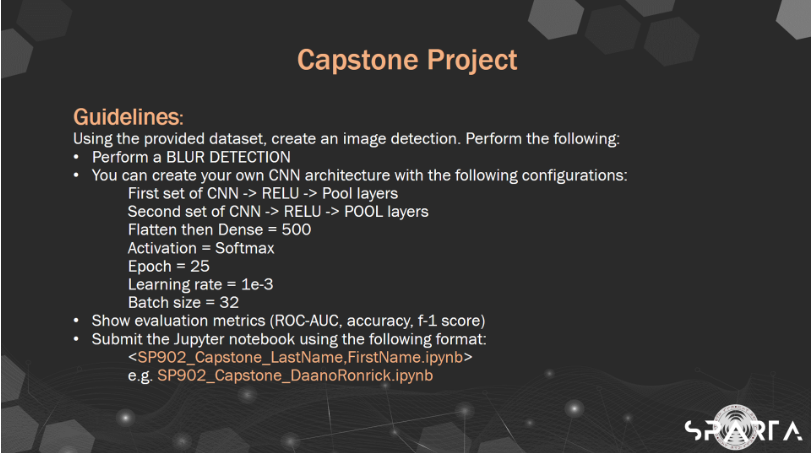

# Installing dependencies

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import cv2
import imghdr
import os, shutil

# Removing Dodgy Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = r'/content/drive/MyDrive/datasets/blur detection'
image_exts = ['jpeg','jpg']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Data Preprocessing

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/datasets/blur detection',image_size=(80, 256))

Found 421 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

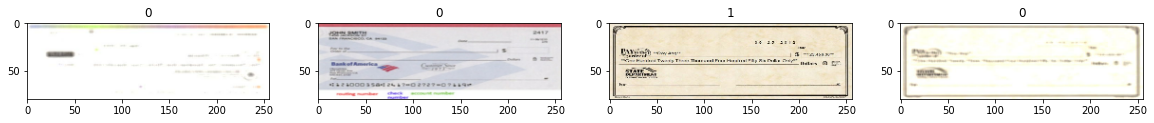

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))

    ax[idx].title.set_text(batch[1][idx])

**0 for blurred while 1 for not blurred images.**

# Scaling data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

# Splitting Data

In [ ]:
len(data)

14

In [ ]:
train_size = int(len(data)*.8)
test_size = int(len(data)*.2)+1

test_size+train_size

14

In [ ]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

# Building the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80,256,3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(500, activation='relu'))
model1.add(layers.Dense(1, activation='softmax'))


model1.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['acc','AUC','Precision','Recall'])

In [ ]:
history = model1.fit(train,
                    epochs=25,
                    batch_size=32,
                    validation_data=test)

Epoch 1/25
11/11 [==============================] - 23s 2s/step - loss: 9.4395 - acc: 0.5142 - auc: 0.5000 - precision: 0.5142 - recall: 1.0000 - val_loss: 0.8511 - val_acc: 0.5072 - val_auc: 0.5000 - val_precision: 0.5072 - val_recall: 1.0000
Epoch 2/25
11/11 [==============================] - 18s 2s/step - loss: 1.1173 - acc: 0.5114 - auc: 0.5000 - precision: 0.5114 - recall: 1.0000 - val_loss: 0.4938 - val_acc: 0.4493 - val_auc: 0.5000 - val_precision: 0.4493 - val_recall: 1.0000
Epoch 3/25
11/11 [==============================] - 15s 1s/step - loss: 0.5529 - acc: 0.5142 - auc: 0.5000 - precision: 0.5142 - recall: 1.0000 - val_loss: 0.3791 - val_acc: 0.4493 - val_auc: 0.5000 - val_precision: 0.4493 - val_recall: 1.0000
Epoch 4/25
11/11 [==============================] - 17s 1s/step - loss: 0.3779 - acc: 0.4972 - auc: 0.5000 - precision: 0.4972 - recall: 1.0000 - val_loss: 0.2423 - val_acc: 0.4638 - val_auc: 0.5000 - val_precision: 0.4638 - val_recall: 1.0000
Epoch 5/25
11/11 [======

# Evaluating Model

**Accuracy**

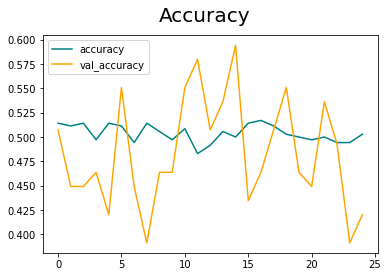

In [ ]:
fig = plt.figure()
plt.plot(history.history['acc'], color='teal', label='accuracy')
plt.plot(history.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**ROC-AUC**

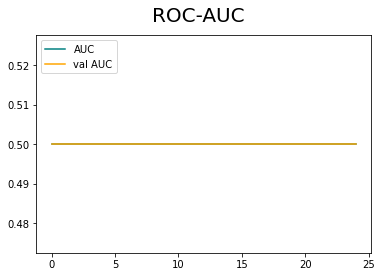

In [ ]:
fig = plt.figure()
plt.plot(history.history['auc'], color='teal', label='AUC')
plt.plot(history.history['val_auc'], color='orange', label='val AUC')
fig.suptitle('ROC-AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**F1 Score**

**Since there is no built in F1-Score metric in Keras. I will built it from precision and recall of the model**

In [ ]:
#@title
m1_f1score = []
for p,r in zip(history.history['precision'],history.history['recall']):
    f1 = 2.0*(p*r)/(p+r)
    m1_f1score.append(f1)
    
m1_val_f1score = []
for p,r in zip(history.history['val_precision'],history.history['val_recall']):
    f1 = 2.0*(p*r)/(p+r)
    m1_val_f1score .append(f1)

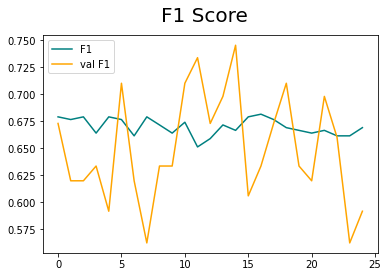

In [ ]:
fig = plt.figure()
plt.plot(m1_f1score, color='teal', label='F1')
plt.plot(m1_val_f1score, color='orange', label='val F1')
fig.suptitle('F1 Score', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**As we can see for the three metrics, it is only around 50-65% accuracy for the validation data. Please do know that the configuration of the CNN was specified on the task so as we can see, it doesn't predict blur detection accurately. </br>
Now, i want to try another model by changing some configuration from the first model which can be seen below.**

# New Model

**In this second model, there are only 2 things that i change compared to the previous model and these are:**



1.   Changing the activation of the last dense layer from 'softmax' into 'sigmoid'.
2.   Changing the optimizer from 'RMSProp' into 'Adam'.





In [ ]:
from tensorflow.keras.optimizers import Adam
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80,256,3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(500, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))


model2.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['acc','AUC','Precision','Recall'])

In [ ]:
history2 = model2.fit(train,
                    epochs=10,
                    batch_size=32,
                    validation_data=test)

Epoch 1/10
11/11 [==============================] - 17s 1s/step - loss: 3.9315 - acc: 0.5398 - auc: 0.5432 - precision: 0.5515 - recall: 0.5879 - val_loss: 0.5996 - val_acc: 0.7681 - val_auc: 0.9277 - val_precision: 1.0000 - val_recall: 0.4074
Epoch 2/10
11/11 [==============================] - 15s 1s/step - loss: 0.6419 - acc: 0.6165 - auc: 0.6571 - precision: 0.6301 - recall: 0.6056 - val_loss: 0.5011 - val_acc: 0.7681 - val_auc: 0.9529 - val_precision: 1.0000 - val_recall: 0.5429
Epoch 3/10
11/11 [==============================] - 15s 1s/step - loss: 0.4887 - acc: 0.7670 - auc: 0.8485 - precision: 0.7949 - recall: 0.7126 - val_loss: 0.4832 - val_acc: 0.8116 - val_auc: 0.9569 - val_precision: 0.7400 - val_recall: 1.0000
Epoch 4/10
11/11 [==============================] - 16s 1s/step - loss: 0.3101 - acc: 0.8722 - auc: 0.9515 - precision: 0.8830 - recall: 0.8580 - val_loss: 0.2067 - val_acc: 0.9420 - val_auc: 0.9857 - val_precision: 0.9231 - val_recall: 0.9231
Epoch 5/10
11/11 [======

# Evaluating 2nd model

**Accuracy**

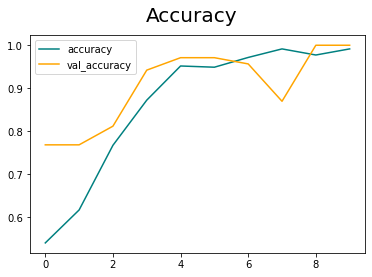

In [ ]:
fig = plt.figure()
plt.plot(history2.history['acc'], color='teal', label='accuracy')
plt.plot(history2.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**ROC-AUC**

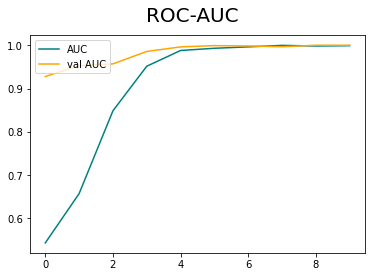

In [ ]:
fig = plt.figure()
plt.plot(history2.history['auc'], color='teal', label='AUC')
plt.plot(history2.history['val_auc'], color='orange', label='val AUC')
fig.suptitle('ROC-AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**F1 Score**

In [ ]:
#@title
m2_f1score = []
for p,r in zip(history2.history['precision'],history2.history['recall']):
    f1 = 2.0*(p*r)/(p+r)
    m2_f1score.append(f1)
    
m2_val_f1score = []
for p,r in zip(history2.history['val_precision'],history2.history['val_recall']):
    f1 = 2.0*(p*r)/(p+r)
    m2_val_f1score .append(f1)

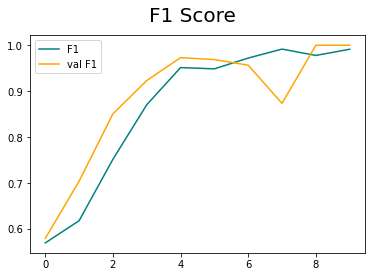

In [ ]:
fig = plt.figure()
plt.plot(m2_f1score, color='teal', label='F1')
plt.plot(m2_val_f1score, color='orange', label='val F1')
fig.suptitle('F1 Score', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**As we can see at the evaluation metrics above, model 2 is better than model 1 at performing blur detection.**